In [ ]:
#Downloading the Malaria Dataset from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria?
from google.colab import drive
drive.mount('/content/gdrive')
 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
 
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip 'cell-images-for-detecting-malaria.zip' -d 'data'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
data_dir = pathlib.Path('data/cell_images')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [ ]:
def resize_image(path, new_width = 150, new_height = 150):
  im = PIL.Image.open(path)
  if im.size != (new_width, new_height):
    im = im.resize((new_width, new_height))
    im.save(path)

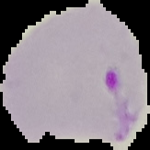

In [ ]:
parasitisized = list(data_dir.glob('Parasitized/*'))
PIL.Image.open(str(parasitisized[0]))

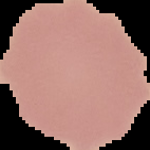

In [ ]:
uninfected = list(data_dir.glob('Uninfected/*'))
PIL.Image.open(str(uninfected[0]))

In [ ]:
im = PIL.Image.open(str(parasitisized[6000]))
print(im.size)

(150, 150)


In [4]:
j = 0
for i in parasitisized:
  if str(i).endswith('png'):
    try:
      resize_image(str(i))
      print(j)
      j += 1
    except:
      !rm str(i)
      continue

In [5]:
j = 0
for i in uninfected:
  if str(i).endswith('png'):
    try:
      resize_image(str(i))
      print(j)
      j += 1
    except:
      !rm str(i)
      continue

In [ ]:
import shutil

shutil.rmtree('data/cell_images/cell_images')

In [ ]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.0 0.92549026


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [6]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
def predict_image(path):
  img = keras.preprocessing.image.load_img(
      path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  return [(class_names[np.argmax(score)]), 100 * np.max(score)]

In [ ]:
print(predict_image(path = 'parasitiz.png'))

This image most likely belongs to Parasitized with a 99.94841814041138 percent confidence.
['Parasitized', 99.94841814041138]


In [ ]:
model.save('malaria_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: malaria_model/assets


In [ ]:
!zip -r /content/file.zip /content/malaria_model

  adding: content/malaria_model/ (stored 0%)
  adding: content/malaria_model/saved_model.pb (deflated 88%)
  adding: content/malaria_model/variables/ (stored 0%)
  adding: content/malaria_model/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/malaria_model/variables/variables.index (deflated 66%)
  adding: content/malaria_model/assets/ (stored 0%)
